In [1]:
import os
import json
import numpy as np
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
import gpflow
import tensorflow as tf

from hm_pyfunctions import *

2025-11-14 11:50:18.478139: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-14 11:50:18.493360: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763146218.505640   82716 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763146218.509452   82716 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-11-14 11:50:18.528982: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [3]:
# get config information
utils_dir = '/glade/u/home/linnia/CLM6-PPE/utils/'

with open(os.path.join(utils_dir, "param_info.json"), "r") as f:
    param_info = json.load(f)
u_params = param_info['u_params']
pft_params = param_info['pft_params']

with open(os.path.join(utils_dir, "biome_info.json"), "r") as f:
    biome_info = json.load(f)

In [4]:
### Load data
ds_params_norm = xr.open_dataset('/glade/work/linnia/CLM6-PPE/ctsm53065_lhc/clm6lhc_10092025.nc')
ds_lhc = xr.open_dataset('/glade/work/linnia/CLM6-PPE/ctsm53065_lhc/postp/ctsm53065_lhc_pxbmean_1985-2014.nc')

In [5]:
# tmp (drop crashers)
ds_params_norm = ds_params_norm.isel(ens=slice(0,100))
ds_lhc = ds_lhc.isel(ens=slice(0,101))

ix = np.isnan(ds_lhc.NPP_biome_amean.isel(biome=1,year=1))
crashers_ix = np.argwhere(ix.values).flatten()

ds_params_norm = ds_params_norm.drop_sel(ens=crashers_ix)
ds_lhc = ds_lhc.drop_sel(ens=crashers_ix)

In [6]:
# train test split (same for all emulators)
np.random.seed(42)
ntest = 10
biome_pfts = biome_info['13']['pfts_in_biome']
X = build_biome_X(ds_params_norm.lhc_params,u_params,pft_params,biome_pfts)
ix_test = np.random.choice(np.arange(len(X)), size=ntest, replace=False)
ix_train = np.where(~np.isin(np.arange(len(X)), ix_test))[0]


2025-11-14 11:50:33.048377: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


INFO:tensorflow:Assets written to: ./emulators/biome_lai_1/assets


INFO:tensorflow:Assets written to: ./emulators/biome_lai_1/assets


INFO:tensorflow:Assets written to: ./emulators/biome_lai_2/assets


INFO:tensorflow:Assets written to: ./emulators/biome_lai_2/assets


INFO:tensorflow:Assets written to: ./emulators/biome_lai_3/assets


INFO:tensorflow:Assets written to: ./emulators/biome_lai_3/assets


INFO:tensorflow:Assets written to: ./emulators/biome_lai_4/assets


INFO:tensorflow:Assets written to: ./emulators/biome_lai_4/assets


INFO:tensorflow:Assets written to: ./emulators/biome_lai_5/assets


INFO:tensorflow:Assets written to: ./emulators/biome_lai_5/assets


INFO:tensorflow:Assets written to: ./emulators/biome_lai_6/assets


INFO:tensorflow:Assets written to: ./emulators/biome_lai_6/assets


INFO:tensorflow:Assets written to: ./emulators/biome_lai_7/assets


INFO:tensorflow:Assets written to: ./emulators/biome_lai_7/assets


INFO:tensorflow:Assets written to: ./emulators/biome_lai_8/assets


INFO:tensorflow:Assets written to: ./emulators/biome_lai_8/assets


INFO:tensorflow:Assets written to: ./emulators/biome_lai_9/assets


INFO:tensorflow:Assets written to: ./emulators/biome_lai_9/assets


INFO:tensorflow:Assets written to: ./emulators/biome_lai_10/assets


INFO:tensorflow:Assets written to: ./emulators/biome_lai_10/assets


INFO:tensorflow:Assets written to: ./emulators/biome_lai_11/assets


INFO:tensorflow:Assets written to: ./emulators/biome_lai_11/assets


INFO:tensorflow:Assets written to: ./emulators/biome_lai_12/assets


INFO:tensorflow:Assets written to: ./emulators/biome_lai_12/assets


INFO:tensorflow:Assets written to: ./emulators/biome_lai_13/assets


INFO:tensorflow:Assets written to: ./emulators/biome_lai_13/assets


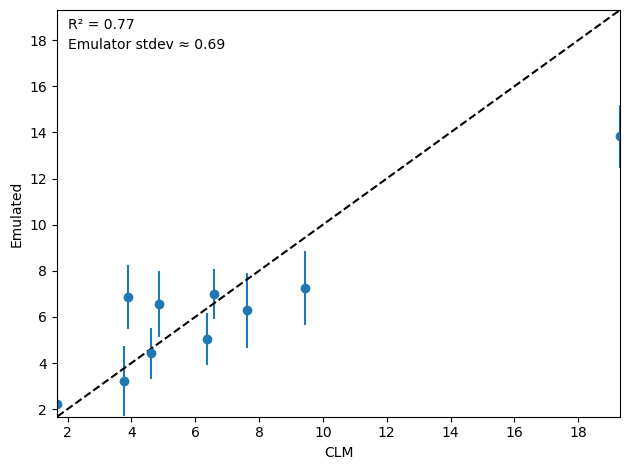

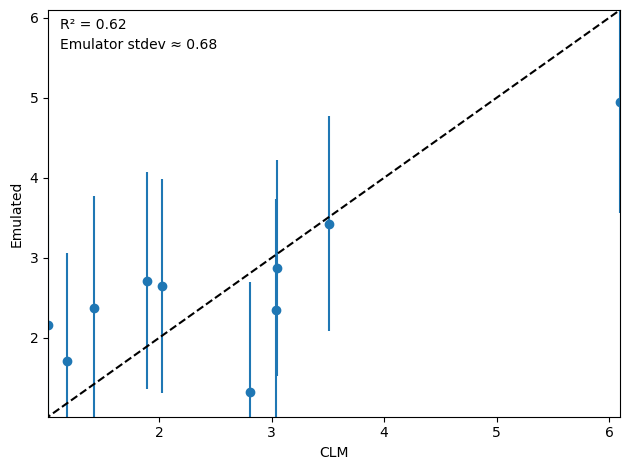

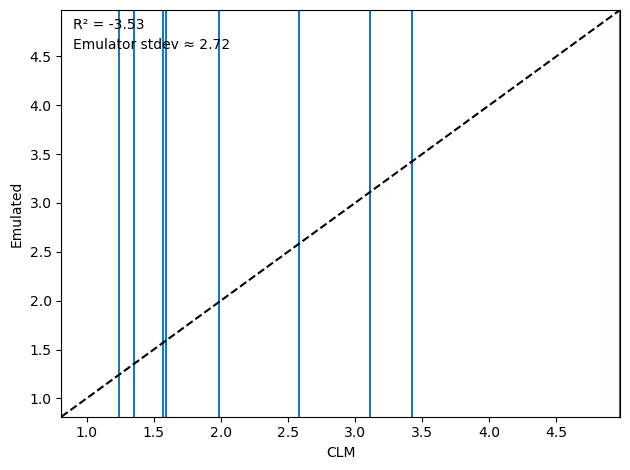

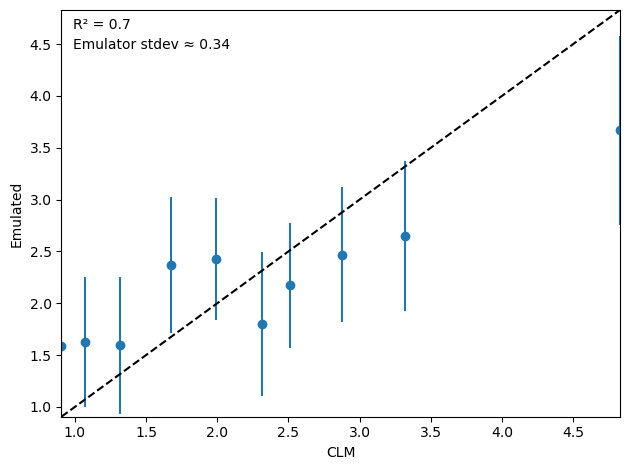

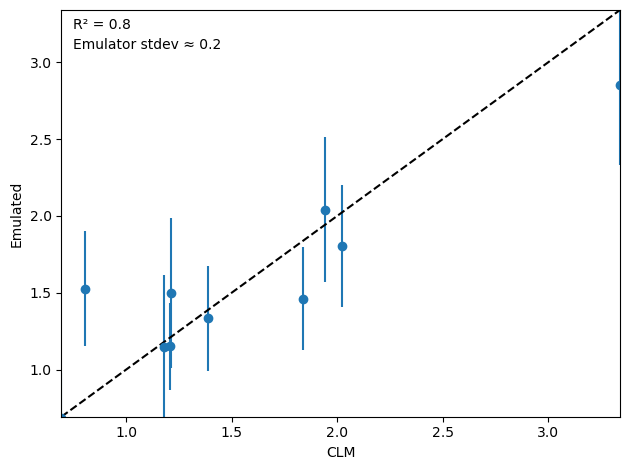

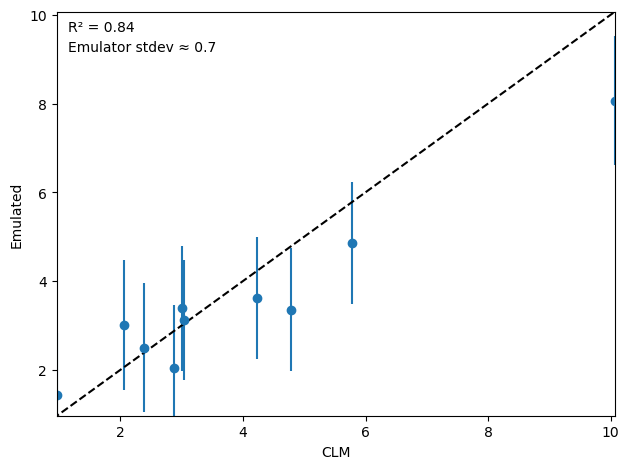

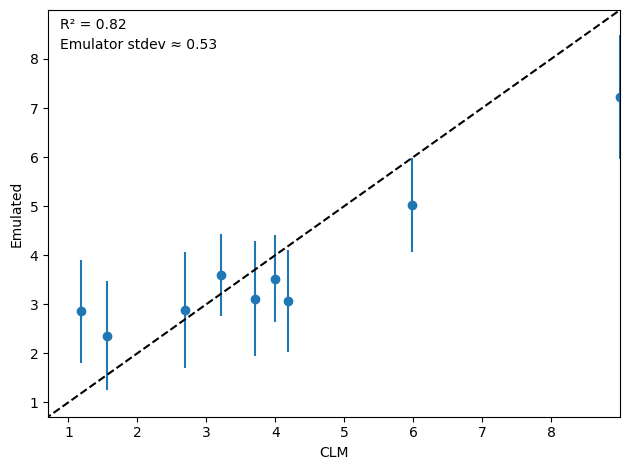

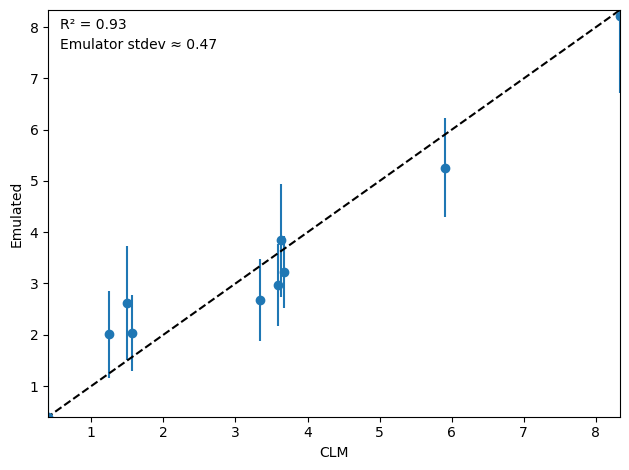

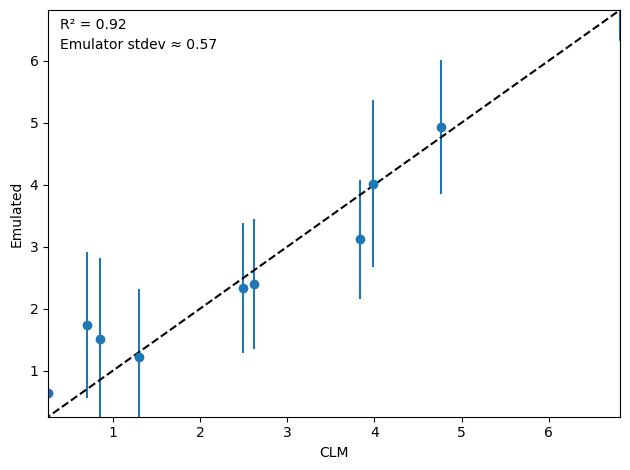

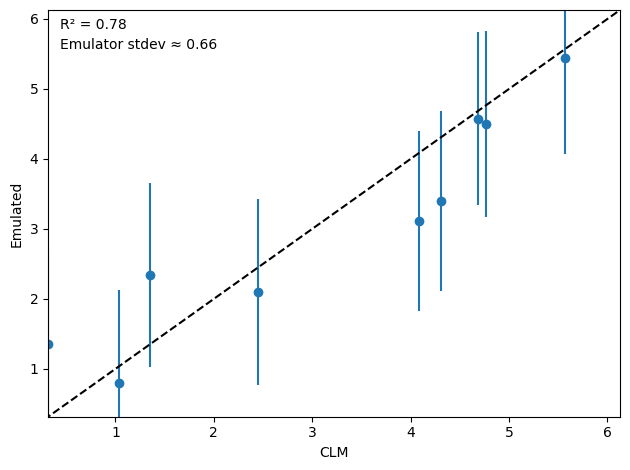

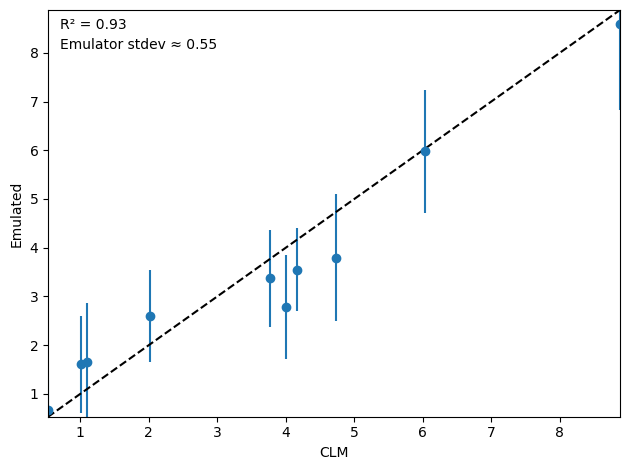

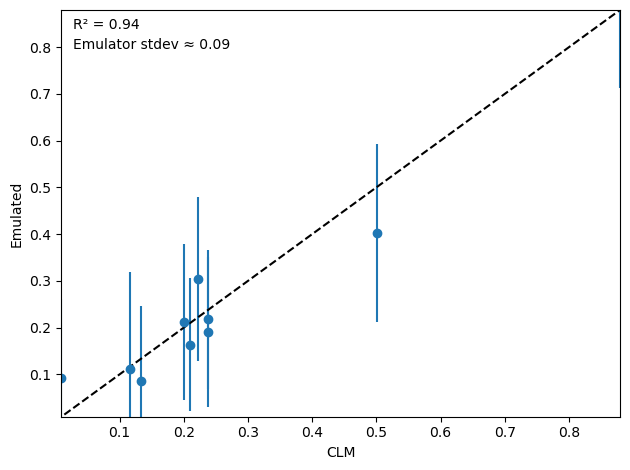

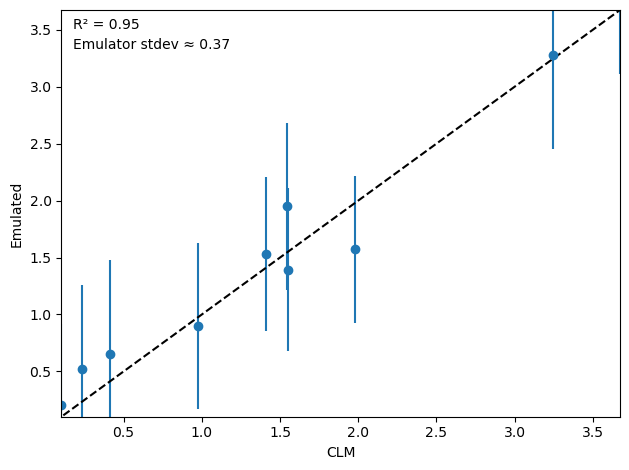

In [7]:
# Train LAI emulators
start_year = '1990'
end_year = '2014'
y_data = ds_lhc.TLAI_biome_amax.sel(year=slice(start_year,end_year),ens=slice(1,101)).mean(dim='year')

emulator_save_dir = './emulators/biome_lai_'
validation_fig_dir = './figs/emulator_validation_laimax_biome'

for b in range(1,14):
    
    biome_pfts = biome_info[str(b)]['pfts_in_biome']
    X = build_biome_X(ds_params_norm.lhc_params,u_params,pft_params,biome_pfts)
    Y = y_data.sel(biome=b).values
    X_test, X_train = X[ix_test,:], X[ix_train,:]
    y_test, y_train = Y[ix_test].reshape(-1,1), Y[ix_train].reshape(-1,1)

    # build kernel
    num_params = np.shape(X)[1]
    kernel_dict = build_kernel_dict(num_params)
    best_kernel = select_kernel(kernel_dict,X_train,X_test,y_train,y_test)
    #best_kernel = kernel_dict[4]

    # Train 
    emulator = train_model(X_train, y_train, best_kernel)

    # Validate
    y_pred, sd, coef_deter = validate_model(emulator, X_test, y_test)

    # Save 
    savedir = str(emulator_save_dir+str(b))
    save_model(emulator, savedir, num_params)

    # Plot the validation
    outfile = validation_fig_dir+str(b)+'.png'
    plot_emulator_val(y_test, y_pred, sd, coef_deter, outfile)


In [ ]:
# Train GPP emulators # (2001,2015)
start_year = '2001'
end_year = '2014'
y_data = (60*60*24*ds_lhc.GPP_biome_amean).sel(year=slice(start_year,end_year),ens=slice(1,101)).mean(dim='year')

emulator_save_dir = './emulators/biome_gpp_'
validation_fig_dir = './figs/emulator_validation_gpp_biome'

for b in range(1,14):
    
    biome_pfts = biome_info[str(b)]['pfts_in_biome']
    X = build_biome_X(ds_params_norm.lhc_params,u_params,pft_params,biome_pfts)
    Y = y_data.sel(biome=b).values
    X_test, X_train = X[ix_test,:], X[ix_train,:]
    y_test, y_train = Y[ix_test].reshape(-1,1), Y[ix_train].reshape(-1,1)

    # build kernel
    num_params = np.shape(X)[1]
    kernel_dict = build_kernel_dict(num_params)
    best_kernel = select_kernel(kernel_dict,X_train,X_test,y_train,y_test)
    #best_kernel = kernel_dict[4]

    # Train 
    emulator = train_model(X_train, y_train, best_kernel)

    # Validate
    y_pred, sd, coef_deter = validate_model(emulator, X_test, y_test)

    # Save 
    savedir = str(emulator_save_dir+str(b))
    save_model(emulator, savedir, num_params)

    # Plot the validation
    outfile = validation_fig_dir+str(b)+'.png'
    plot_emulator_val(y_test, y_pred, sd, coef_deter, outfile)


In [ ]:
# Train tvc emulators # (2000,2019)
start_year = '2001'
end_year = '2014'
y_data = ((1/1000)*ds_lhc.TOTVEGC_biome_amean).sel(year=slice(start_year,end_year),ens=slice(1,101)).mean(dim='year')

emulator_save_dir = './emulators/biome_gpp_'
validation_fig_dir = './figs/emulator_validation_gpp_biome'

for b in range(1,14):
    
    biome_pfts = biome_info[str(b)]['pfts_in_biome']
    X = build_biome_X(ds_params_norm.lhc_params,u_params,pft_params,biome_pfts)
    Y = y_data.sel(biome=b).values
    X_test, X_train = X[ix_test,:], X[ix_train,:]
    y_test, y_train = Y[ix_test].reshape(-1,1), Y[ix_train].reshape(-1,1)

    # build kernel
    num_params = np.shape(X)[1]
    kernel_dict = build_kernel_dict(num_params)
    best_kernel = select_kernel(kernel_dict,X_train,X_test,y_train,y_test)
    #best_kernel = kernel_dict[4]

    # Train 
    emulator = train_model(X_train, y_train, best_kernel)

    # Validate
    y_pred, sd, coef_deter = validate_model(emulator, X_test, y_test)

    # Save 
    savedir = str(emulator_save_dir+str(b))
    save_model(emulator, savedir, num_params)

    # Plot the validation
    outfile = validation_fig_dir+str(b)+'.png'
    plot_emulator_val(y_test, y_pred, sd, coef_deter, outfile)


In [2]:
# ET, albedo?, SH?, 

### SANITY CHECK!